In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['HF_DATASETS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['TRANSFORMERS_OFFLINE'] = '1'

In [3]:
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import spacy_alignments as tokenizations
import numpy as np
import pandas as pd
import seaborn as sns
from transformer_lens.utils import gelu_fast
import math
import torch
from probing_datasets.ewt import *
from activations.activation_all import load_activation_all
from circuitsvis.tokens import colored_tokens
import einops
from activations.activation_subset import load_activation_subset

from load import *

%load_ext autoreload
%autoreload 2


%matplotlib inline

In [4]:
model = load_model('pythia-70m')
decoded_vocab = {v: model.to_string(v) for k, v in model.tokenizer.get_vocab().items()}
idecoded_vocab = {v: k for k, v in decoded_vocab.items()}

No pythia-70m-v0 available


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer


In [5]:
ewt = load_feature_dataset('ewt.pyth.512.-1')
noi = pd.read_csv('interpretable_neurons/pythia-6.9b/all_neurons_of_interest.csv')
noi.query("dataset == 'ewt.pyth.512.-1' and feature == 'eos_True'")

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


,model,dataset,feature,layer,neuron,test_mcc,test_f1_score,test_precision,test_recall,coef
569,pythia-6.9b,ewt.pyth.512.-1,eos_True,20,170,0.971523,0.977265,0.971822,0.982770,2.232324
595,pythia-6.9b,ewt.pyth.512.-1,eos_True,17,10481,0.959051,0.966981,0.983550,0.950961,6.553199


In [6]:
ewt = load_feature_dataset('ewt.pyth.512.-1')
noi = pd.read_csv('interpretable_neurons/pythia-6.9b/top_mono_neurons.csv')
noi.query("dataset == 'ewt.pyth.512.-1' and feature == 'eos_True'")

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


,model,dataset,feature,layer,neuron,test_mcc,test_f1_score,test_precision,test_recall,coef
14,pythia-6.9b,ewt.pyth.512.-1,eos_True,20,170,0.971523,0.977265,0.971822,0.98277,2.232324


In [7]:
eos_neurons = [
    ('pythia-70m', 4, 1186),
    ('pythia-160m', 9, 2730),
    ('pythia-410m', 18, 174),
    ('pythia-1b', 12, 1376),
    ('pythia-1.4b', 16, 4808)
]

In [8]:

#act_dict, meta = load_activation_subset(model_name, dataset_name, experiment_name)

In [9]:
model.W_out.shape

torch.Size([6, 2048, 512])

In [10]:
model_name = 'pythia-70m'
dataset_name = 'ewt.pyth.512.-1'
experiment_name = 'top_mono_neurons'

eos_neurons = [
    ('pythia-70m', 4, 1186),
    ('pythia-160m', 9, 2730),
    ('pythia-410m', 18, 174),
    #('pythia-1b', 12, 1376),
    #('pythia-1.4b', 16, 4808)
]

eos_neuron_plot_data = {}

for m, l, n in eos_neurons:
    act_dict, meta = load_activation_subset(m, dataset_name, experiment_name)
    activations = act_dict[(l, n)]

    model = load_model(m)
    output_weight = model.W_out[l, n, :]
    dim_tokens = np.array([decoded_vocab.get(i, 'unk') for i in range(model.W_U.shape[1])])
    logit_attribution = (model.W_U.T @ output_weight).numpy()


    eos_neuron_plot_data[(m, l, n)] = {
        'logit_attribution': logit_attribution,
        'activation': activations
    }

No pythia-70m-v0 available


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer
No pythia-160m-v0 available


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-160m into HookedTransformer
No pythia-410m-v0 available


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-410m into HookedTransformer


In [11]:
token_vec = ewt['tokens'][ewt['tokens'] > 1].numpy()

non_pad_ix = ewt['tokens'] > 1
feature_condition = ewt['eos'] == 1#torch.roll(ewt['eos'], -1, dims=1) # next token is eos
feature_label = feature_condition[non_pad_ix].numpy().astype(bool)

adfs = []
for (m, l, n), d in eos_neuron_plot_data.items():
    act = d['activation'].dequantize().numpy().astype(np.float32)[non_pad_ix]

    adf = pd.DataFrame({
        'token': token_vec,
        'string': [model.to_string(t) for t in token_vec],
        'pos': einops.repeat(torch.arange(512), 'l -> b l', b=len(ewt))[non_pad_ix].numpy(),
        'seq_ix': einops.repeat(torch.arange(len(ewt)), 'b -> b l', l=512)[non_pad_ix].numpy(),
        'activation': act,
        'eos': feature_label,
        'neuron': f'{m.split("-")[1].upper()}.L{l}.N{n}'
    })
    adfs.append(adf)

eos_adf = pd.concat(adfs)

In [12]:
text_tokens = np.array([len(t.strip()) > 0 and t.strip().isalpha() for t in dim_tokens])
all_cap_tokens = np.array([len(t.strip()) > 0 and t.strip().isupper() for t in dim_tokens])
cap_tokens = np.array([len(t.strip()) > 0 and t.strip()[0].isupper() and not all_cap_tokens[ix] for ix, t in enumerate(dim_tokens)])
low_tokens = np.array([len(t.strip()) > 0 and t.strip()[0].islower() for t in dim_tokens])
# cap tokens that have lower version
vocab_set = set([t.strip() for t in dim_tokens])
valid_cap_tokens = np.array([t.lower() in vocab_set and cap_tokens[ix] for ix, t in enumerate(dim_tokens)])
invalid_cap_tokens = ~valid_cap_tokens & cap_tokens

logit_dfs = []
for (m, l, n), d in eos_neuron_plot_data.items():
    logit_df = pd.DataFrame({
        'str': dim_tokens,
        'logit_attribution': d['logit_attribution'],
        'token': '',
        'neuron': f'{m.split("-")[1].upper()}.L{l}.N{n}'
    })
    logit_df.loc[~text_tokens, 'token'] = 'not text'
    logit_df.loc[valid_cap_tokens, 'token'] = 'Uppercase'
    logit_df.loc[invalid_cap_tokens, 'token'] = 'InvalidUpper'
    logit_df.loc[low_tokens, 'token'] = 'lowercase'
    logit_df.loc[all_cap_tokens, 'token'] = 'ALL CAPS'

    logit_dfs.append(logit_df)

logit_df = pd.concat(logit_dfs)
logit_df = logit_df[logit_df['token'].str.endswith('case')]

<AxesSubplot: xlabel='neuron', ylabel='logit_attribution'>

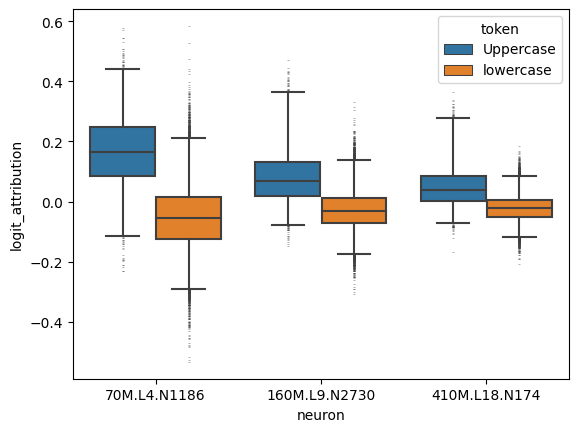

In [13]:

sns.boxplot(data=logit_df, x='neuron', y='logit_attribution', hue='token', whis=(1, 99), fliersize=0.1, hue_order=['Uppercase', 'lowercase'])

In [97]:
n = "70M.L4.N1186"

def case_heatmap(n, logit_df, k=20, ax=None, vmin=-1, vmax=1):
    n_logit_df = logit_df.query('neuron == @n').sort_values('logit_attribution', ascending=False)

    top_upper = n_logit_df.query('token == "Uppercase"').head(k)
    top_lower = n_logit_df.query('token == "lowercase"').head(k)

    min_upper = n_logit_df.query('token == "Uppercase"').tail(k)

    vocab_matrix = np.concatenate([top_upper['str'].values, min_upper['str'].values[::-1], top_lower['str'].values]).reshape(3, k).T
    logit_matrix = np.concatenate([top_upper['logit_attribution'].values, min_upper['logit_attribution'].values[::-1], top_lower['logit_attribution'].values]).reshape(3, k).T

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    sns.heatmap(logit_matrix, annot=vocab_matrix,  fmt='', annot_kws={'fontsize': 9}, cbar=False, ax=ax, vmin=vmin, vmax=vmax)
    # turn off ticks and tick labels
    ax.set_yticks([])
    ax.set_xticks([])


/var/folders/8f/qz9dtbzx2s77drzzcdl8xztm0000gn/T/ipykernel_70220/1315678742.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


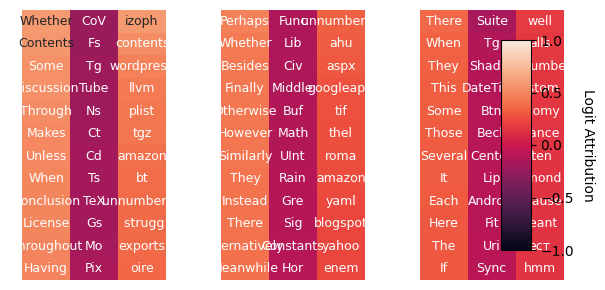

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(6, 3))

ns = ["70M.L4.N1186", "160M.L9.N2730", "410M.L18.N174"]
for n, ax in zip(ns, axs):
    case_heatmap(n, logit_df, ax=ax, k=12)
# add shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
cbar.set_label('Logit Attribution', rotation=270, labelpad=15)
fig.tight_layout()

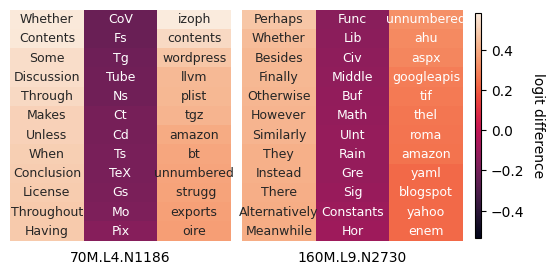

In [114]:

# Example of creating the plots
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

ns = ["70M.L4.N1186", "160M.L9.N2730"]

# Determine the common vmin and vmax for all heatmaps
all_values = np.array([])
for n in ns:
    n_logit_df = logit_df.query('neuron == @n').sort_values('logit_attribution', ascending=False)
    all_values = np.concatenate([all_values, n_logit_df['logit_attribution'].values])
vmin, vmax = all_values.min(), all_values.max()

for n, ax in zip(ns, axs):
    case_heatmap(n, logit_df, ax=ax, k=12, vmin=vmin, vmax=vmax)

fig.subplots_adjust(wspace=0.02)
# Adjust spacing between subplots and add shared colorbar
fig.subplots_adjust(right=0.88, wspace=0.05)  # Adjust wspace parameter to control the space between subplots
cbar_ax = fig.add_axes([0.9, 0.12, 0.01, 0.75])
cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
cbar.set_label('logit difference', rotation=270, labelpad=15)
axs[0].set_xlabel(ns[0])
axs[1].set_xlabel(ns[1])

plt.savefig('figures/case_vocab.png', bbox_inches='tight')

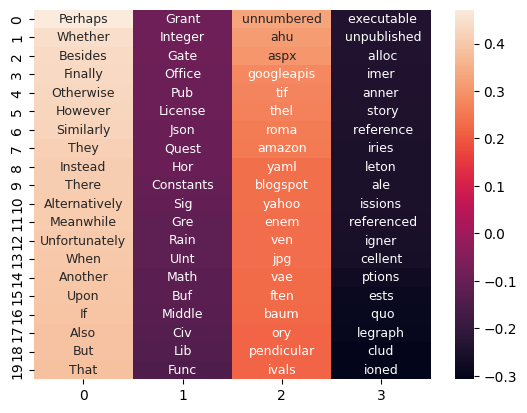

In [65]:
case_heatmap('160M.L9.N2730', logit_df)

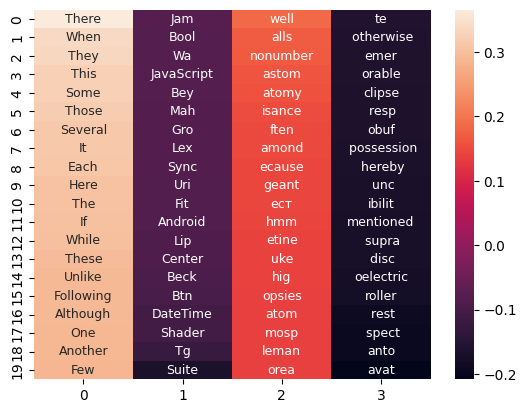

In [66]:
case_heatmap('410M.L18.N174', logit_df)

In [60]:
logit_df.neuron.unique()

array(['70M.L4.N1186', '160M.L9.N2730', '410M.L18.N174'], dtype=object)

In [53]:
logit_matrix

array([[ 0.58485496,  0.52901953,  0.47506344,  0.43994173,  0.4362128 ,
         0.42575085,  0.39755753,  0.38730618,  0.38123932,  0.37541443],
       [ 0.57822263,  0.57222927,  0.5446253 ,  0.54371107,  0.53080684,
         0.50774014,  0.50702393,  0.49980554,  0.4960943 ,  0.49263808],
       [-0.45351222, -0.45565757, -0.45670614, -0.47097468, -0.47916195,
        -0.48146424, -0.48455977, -0.51851714, -0.5279927 , -0.53421944],
       [-0.18817024, -0.1930647 , -0.19315912, -0.19449317, -0.1969464 ,
        -0.21165255, -0.21181968, -0.21792996, -0.2319207 , -0.23213997]],
      dtype=float32)

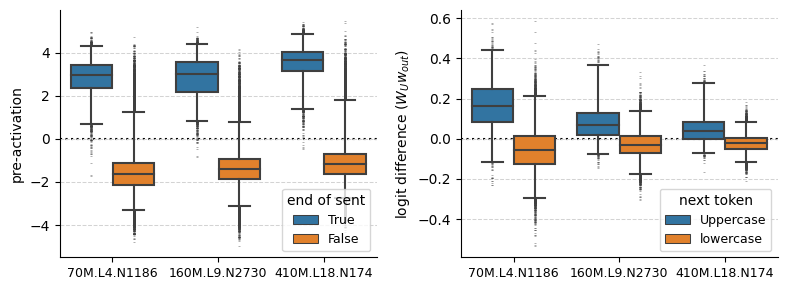

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(data=eos_adf, x='neuron', y='activation', hue='eos', whis=(1, 99), fliersize=0.1, hue_order=[True, False], ax=axs[0])
sns.boxplot(data=logit_df, x='neuron', y='logit_attribution', hue='token', whis=(1, 99), fliersize=0.1, hue_order=['Uppercase', 'lowercase'], ax=axs[1])

axs[0].legend(title='end of sent', loc='lower right', fontsize=9)
axs[1].legend(title='next token', loc='lower right', fontsize=9)

axs[0].set_ylabel('pre-activation')
axs[1].set_ylabel('logit difference ($W_U w_{out}$)')

# change x tick font size
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=-1)
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.75)
    ax.set_xlabel(None)
    # set grid behind plot elements
    ax.set_axisbelow(True)
plt.tight_layout()
#plt.suptitle('End of sentence neurons', fontsize=12, y=1.02)



plt.savefig('figures/eos-neurons.png', bbox_inches='tight')

In [29]:

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(data=eos_adf, x='neuron', y='activation', hue='eos', whis=(1, 99), fliersize=0.1, hue_order=[True, False], ax=axs[0])
sns.boxplot(data=logit_df, x='neuron', y='logit_attribution', hue='token', whis=(1, 99), fliersize=0.1, hue_order=['Uppercase', 'lowercase'], ax=axs[1])

axs[0].legend(title='end of sent', loc='lower right', fontsize=9)
axs[1].legend(title='next token', loc='lower right', fontsize=9)

axs[0].set_ylabel('pre-activation')
axs[1].set_ylabel('logit difference ($W_U w_{out}$)')

# change x tick font size
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=-1)
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.75)
    ax.set_xlabel(None)
    # set grid behind plot elements
    ax.set_axisbelow(True)
plt.tight_layout()
plt.suptitle('End of sentence neurons', fontsize=12, y=1.02)



plt.savefig('figures/eos-neurons.png', bbox_inches='tight')


# Example of creating the plots
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

ns = ["70M.L4.N1186", "160M.L9.N2730"]

# Determine the common vmin and vmax for all heatmaps
all_values = np.array([])
for n in ns:
    n_logit_df = logit_df.query('neuron == @n').sort_values('logit_attribution', ascending=False)
    all_values = np.concatenate([all_values, n_logit_df['logit_attribution'].values])
vmin, vmax = all_values.min(), all_values.max()

for n, ax in zip(ns, axs):
    case_heatmap(n, logit_df, ax=ax, k=12, vmin=vmin, vmax=vmax)

fig.subplots_adjust(wspace=0.02)
# Adjust spacing between subplots and add shared colorbar
fig.subplots_adjust(right=0.88, wspace=0.05)  # Adjust wspace parameter to control the space between subplots
cbar_ax = fig.add_axes([0.9, 0.12, 0.01, 0.75])
cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
cbar.set_label('logit difference', rotation=270, labelpad=15)
axs[0].set_xlabel(ns[0])
axs[1].set_xlabel(ns[1])

,str,logit_attribution,token,neuron
28334,CoV,-0.232140,Uppercase,70M.L4.N1186
13139,Fs,-0.231921,Uppercase,70M.L4.N1186
41914,Tg,-0.217930,Uppercase,70M.L4.N1186
13813,Tube,-0.211820,Uppercase,70M.L4.N1186
19450,Ns,-0.211653,Uppercase,70M.L4.N1186
5229,Ct,-0.196946,Uppercase,70M.L4.N1186
41094,Cd,-0.194493,Uppercase,70M.L4.N1186
27415,Ts,-0.193159,Uppercase,70M.L4.N1186
48406,TeX,-0.193065,Uppercase,70M.L4.N1186
15121,Gs,-0.188170,Uppercase,70M.L4.N1186


In [35]:
adf.query('eos').sort_values('activation')

,token,string,pos,seq_ix,activation,eos,neuron
121136,904,".,",351,272,-0.460715,True,410M.L18.N174
255594,9944,.;,476,1123,-0.422322,True,410M.L18.N174
244864,15,.,109,910,-0.383929,True,410M.L18.N174
230518,15,.,194,808,-0.307143,True,410M.L18.N174
255646,9944,.;,25,1124,-0.153572,True,410M.L18.N174
...,...,...,...,...,...,...,...
9267,32,?,349,19,5.298218,True,410M.L18.N174
106417,15,.,306,240,5.336611,True,410M.L18.N174
89450,32,?,29,199,5.336611,True,410M.L18.N174
109874,15,.,270,248,5.336611,True,410M.L18.N174


In [46]:
from circuitsvis.tokens import colored_tokens
ix = 121
token_list = adf.query('seq_ix==@ix')['string'].values.tolist()
activation_list = adf.query('seq_ix==@ix')['activation'].values.tolist()

colored_tokens(token_list, activation_list)

In [44]:
token_list[190:]

['or',
 ' privileged',
 ' material',
 '.',
 ' Any',
 ' review',
 ',',
 ' ret',
 'rans',
 'mission',
 ',',
 ' dissemination',
 ' or',
 ' other',
 ' use',
 ' of',
 ',',
 ' or',
 ' taking',
 ' of',
 ' any',
 ' action',
 ' in',
 ' reliance',
 ' upon',
 ',',
 ' this',
 ' information',
 ' by',
 ' persons',
 ' or',
 ' entities',
 ' other',
 ' than',
 ' the',
 ' intended',
 ' recipient',
 ' is',
 ' prohibited',
 '.',
 ' If',
 ' you',
 ' received',
 ' this',
 ' in',
 ' error',
 ',',
 ' please',
 ' contact',
 ' the',
 ' sender',
 ' and',
 ' delete',
 ' the',
 ' material',
 ' from',
 ' all',
 ' computers',
 '."',
 ' Att',
 'ached',
 ' please',
 ' find',
 ' the',
 ' GE',
 ' Guarant',
 'ee',
 ' in',
 ' Word',
 ' format',
 '.?',
 ' Also',
 ',',
 ' we',
 ' have',
 ' attached',
 ' a',
 ' pdf',
 ' black',
 '-',
 'line',
 ' of',
 ' the',
 ' Guarant',
 'ee',
 ' vs',
 ' the',
 ' form',
 ' of',
 ' guarantee',
 ' in',
 ' the',
 ' T',
 'urb',
 'ine',
 ' Contract',
 '.',
 ' Do',
 ' not',
 ' hesitate',
 ' to',